Author: StatsEye - Klaudia Łubian

Date: September 2019

# Predicting churn with XGBoost

This notebook demonstrates how to use *XGBoost* to predict churn of an individual using pre-processed dataset on 10,000 customers. This Python code includes advanced parameter tuning and explanation of the final model's predictions using SHAP values plotted with the *shap* library. 

Gradient boosting machine methods such as XGBoost are state-of-the-art for these types of prediction problems with tabular style input data of many modalities. XGBoost is used nowadays to create some of the most performant prediction models. Tree SHAP allows for fast and exact computation of SHAP values for tree ensemble methods, and has been integrated directly into the C++ XGBoost code base. Here I will demonstrate how to use SHAP values to understand XGBoost model predictions.

# 1. Set up

In [1]:
# Import libraries
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import metrics
import shap
import pickle
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

# Configure plotting
rcParams['figure.figsize'] = 12, 6
%matplotlib inline

# Allow showing all columns in the output
pd.set_option('display.expand_frame_repr', False)

# 2. Data management

## Import dataset and select variables for modelling

In [2]:
# Import data
dataset = pd.read_csv('data/Churn_Modelling.csv')

# Basic info about the variables
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null int64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB
None


In [3]:
# First three columns are not needed for modelling. Drop them from the dataset
dataset = dataset.iloc[:, 3:]

### Encoding of categorical data
Note that XGBoost does not support categorical features

In [4]:
# Check categories of categorical variables
print("Categories of Gender:", dataset["Gender"].unique())
print("Categories of Geography:", dataset["Geography"].unique())

Categories of Gender: ['Female' 'Male']
Categories of Geography: ['France' 'Spain' 'Germany']


In [5]:
# Transform Gender column (create dummies)
labelencoder_X_2 = LabelEncoder()
dataset["Gender"] = labelencoder_X_2.fit_transform(dataset["Gender"])
dataset["Gender"].unique()
print(dataset.info())
print("Categories of Gender:", dataset["Gender"].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null int32
Age                10000 non-null int64
Tenure             10000 non-null int64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(2), int32(1), int64(7), object(1)
memory usage: 820.4+ KB
None
Categories of Gender: [0 1]


In [6]:
# Transform Geography column (create dummies)
dataset['Spain'] = (dataset['Geography'] == 'Spain').map({True: '1', False: '0'})
dataset['Spain']=dataset['Spain'].astype(int)
dataset['Germany'] = (dataset['Geography'] == 'Germany').map({True: '1', False: '0'})
dataset['Germany']=dataset['Germany'].astype(int)
del dataset["Geography"]
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
CreditScore        10000 non-null int64
Gender             10000 non-null int32
Age                10000 non-null int64
Tenure             10000 non-null int64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
Spain              10000 non-null int32
Germany            10000 non-null int32
dtypes: float64(2), int32(3), int64(7)
memory usage: 820.4 KB
None


## Splitting dataset into training and test set

Ideally, the model should be evaluated on samples that were not used to build or fine-tune the model, so that they provide an unbiased sense of model effectiveness. When a large amount of data is at hand, a set of samples can be set aside to evaluate the final model. The training dataset is the general term for the samples used to create the model, while the test or validation data set is used to qualify performance.
Generally, the term *validation set* is used interchangeably with the term *test set* and refers to a sample of the dataset held back from training the model. I will use the terms following the glossary in Brian Ripley’s book (1996) *Pattern Recognition and Neural Networks*:
* Training set: A set of cases used for learning, that is to fit the parameters of the classifier.
* Validation set: A set of cases used to tune the parameters of a classifier, for example to choose the number of hidden units in a neural network.
* Test set: A set of cases used only to assess the performance of a fully-specified classifier.

In [7]:
# Check proportion of cases with churn=1 in the whole dataset 
print(dataset['Exited'].sum() / len(dataset) * 100 )
# no high imbalance of the target class, so no need to adjust scale_pos_weight parameter in XGBoost

20.369999999999997


In [8]:
# Split target variables and predictors
y = dataset['Exited']
X = dataset.drop(['Exited'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123, stratify = y)
print("Number of cases in training dataset:", len(y_train))
print("Number of cases in test dataset:", len(y_test))

Number of cases in training dataset: 8000
Number of cases in test dataset: 2000


In [9]:
# Check if stratification worked 
print("% of Exited in training dataset:", y_train.sum()/ len(y_train) * 100.0)
print("% of Exited in test dataset:", y_test.sum() / len(y_test) * 100.0 )
# there is a similar proportion of cases with churn=1 in two datasets - good!

% of Exited in training dataset: 20.375
% of Exited in test dataset: 20.349999999999998


# 3. XGBoost modelling

## 3.1 Use default values for parameters in order to decide on number of trees for XGBoost
In order to decide on optimal boosting parameters, we need to set some initial values of other parameters. Lets take the default learning rate of 0.1 here and check the optimum number of trees using cv function of xgboost.

Default parameters for class xgboost.XGBClassifier: 
*(max_depth=3, learning_rate=0.1, n_estimators=100, verbosity=1, silent=None, objective='binary:logistic', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, colsample_bynode=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None)*

Documentation on parameters:(https://xgboost.readthedocs.io/en/latest/parameter.html)

I use the tree booster and logistic regression objective in modelling. This indicates that I'll accomplish the task using classic *gradient boosting regression tree* (GBRT), which is a promising method for binary classification.
Though there are 3 types of boosters (gbtrea, dart and gblinear), I’ll consider only tree booster here because it always outperforms the linear booster, while dart is rarely used.

I will fit the initial model and qualify its performance using test dataset and *accuracy* measure. This will serve as a benchmark for comparison with the performance of the final model (once all parameters are optimized). This also allows to use *early_stopping_rounds* option which will help me decide on number of trees necessary for further modelling. 


In [10]:
xgb1 =  XGBClassifier(
 learning_rate =0.1,
 n_estimators=500,
 objective= 'binary:logistic',
 random_state=123)

print("Set early_stopping_rounds to 10% of the size of the training dataset:", 0.01*(len(X_train)))

xgb1.fit(X_train, y_train, 
         eval_set=[(X_train, y_train), (X_test, y_test)],
         eval_metric='auc',
         early_stopping_rounds = 0.01*(len(X_train)),
         verbose=True)
print(xgb1)

# We got 225 as an optimal number of estimators for 0.1 learning rate. Accuracy for the test dataset = 0.871. 

Set early_stopping_rounds to 10% of the size of the training dataset: 80.0
[0]	validation_0-auc:0.79252	validation_1-auc:0.810337
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 80.0 rounds.
[1]	validation_0-auc:0.793496	validation_1-auc:0.811425
[2]	validation_0-auc:0.797229	validation_1-auc:0.814404
[3]	validation_0-auc:0.800978	validation_1-auc:0.817603
[4]	validation_0-auc:0.80734	validation_1-auc:0.823439
[5]	validation_0-auc:0.810101	validation_1-auc:0.825546
[6]	validation_0-auc:0.821564	validation_1-auc:0.833427
[7]	validation_0-auc:0.820742	validation_1-auc:0.83275
[8]	validation_0-auc:0.829718	validation_1-auc:0.837489
[9]	validation_0-auc:0.830888	validation_1-auc:0.838287
[10]	validation_0-auc:0.83478	validation_1-auc:0.843464
[11]	validation_0-auc:0.83518	validation_1-auc:0.844628
[12]	validation_0-auc:0.835343	validation_1-auc:0.844805
[13]	validation_0-auc:0.840297	validatio

[140]	validation_0-auc:0.890423	validation_1-auc:0.869306
[141]	validation_0-auc:0.8907	validation_1-auc:0.869072
[142]	validation_0-auc:0.890798	validation_1-auc:0.869177
[143]	validation_0-auc:0.891014	validation_1-auc:0.869354
[144]	validation_0-auc:0.891296	validation_1-auc:0.869496
[145]	validation_0-auc:0.891375	validation_1-auc:0.869426
[146]	validation_0-auc:0.891386	validation_1-auc:0.869343
[147]	validation_0-auc:0.891455	validation_1-auc:0.869317
[148]	validation_0-auc:0.891527	validation_1-auc:0.869317
[149]	validation_0-auc:0.891534	validation_1-auc:0.869325
[150]	validation_0-auc:0.891809	validation_1-auc:0.869311
[151]	validation_0-auc:0.891863	validation_1-auc:0.869317
[152]	validation_0-auc:0.892125	validation_1-auc:0.869393
[153]	validation_0-auc:0.892309	validation_1-auc:0.869404
[154]	validation_0-auc:0.892507	validation_1-auc:0.869436
[155]	validation_0-auc:0.892712	validation_1-auc:0.869518
[156]	validation_0-auc:0.892989	validation_1-auc:0.869574
[157]	validation

[282]	validation_0-auc:0.911865	validation_1-auc:0.870798
[283]	validation_0-auc:0.911866	validation_1-auc:0.870738
[284]	validation_0-auc:0.911983	validation_1-auc:0.870683
[285]	validation_0-auc:0.912083	validation_1-auc:0.87072
[286]	validation_0-auc:0.912167	validation_1-auc:0.87064
[287]	validation_0-auc:0.912358	validation_1-auc:0.87063
[288]	validation_0-auc:0.912427	validation_1-auc:0.87055
[289]	validation_0-auc:0.912587	validation_1-auc:0.870459
[290]	validation_0-auc:0.912761	validation_1-auc:0.870442
[291]	validation_0-auc:0.912948	validation_1-auc:0.870215
[292]	validation_0-auc:0.91311	validation_1-auc:0.87007
[293]	validation_0-auc:0.913291	validation_1-auc:0.869932
[294]	validation_0-auc:0.913314	validation_1-auc:0.869924
[295]	validation_0-auc:0.913465	validation_1-auc:0.870095
[296]	validation_0-auc:0.913532	validation_1-auc:0.870004
[297]	validation_0-auc:0.91365	validation_1-auc:0.869918
[298]	validation_0-auc:0.913733	validation_1-auc:0.8698
[299]	validation_0-auc:

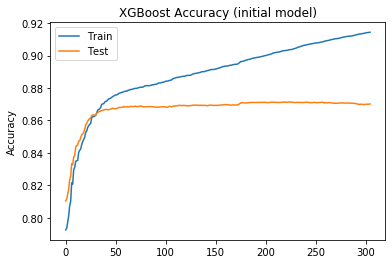

In [11]:
# Visualize training - how AUC improved for training and test dataset

xgb1_evals_result = xgb1.evals_result()
epochs = len(xgb1_evals_result['validation_0']['auc'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, xgb1_evals_result['validation_0']['auc'], label='Train')
ax.plot(x_axis, xgb1_evals_result['validation_1']['auc'], label='Test')
ax.legend()
plt.ylabel('Accuracy')
plt.title('XGBoost Accuracy (initial model)')
plt.show()

The accuracy on test dataset seems to have stabilized at around 60th epoch. 
```
xgb1_evals_result['validation_1']['auc'][60]
```
It's indeed better for iteration 225. However, we are risking over-fitting. Let's set number of trees to 150. 

### Plot Feature Importance for the initial model
*xgb.plot_importance()* gives an attractively simple bar-chart representing the importance of each feature in our dataset. There are three options for measuring feature importance in XGBoost:
* Weight. The number of times a feature is used to split the data across all trees.
* Cover. The number of times a feature is used to split the data across all trees weighted by the number of training data points that go through those splits.
* Gain. The average training loss reduction gained when using a feature for splitting.
    
The *gain* is the most relevant attribute to interpret the relative importance of each feature. It measures the improvement in accuracy brought by a feature to the branches, and it accounts for a number of categories each variable has (the importance of variables with more categories will not be over-estimated, a problem we may have with the *weight* metric). 

However, analyses (https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27) showed that such a widely used method as Gain can lead to inconsistet results. Typically we expect features near the root of the tree to be more important than features split on near the leaves (since trees are constructed greedily). Yet the gain method is biased to attribute more importance to lower splits. As trees get deeper, this bias only grows.
To address this issue, a new approach has been proposed by group of practitioners, described in detail in the paper: (https://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions) and on GitHub: (https://github.com/slundberg/shap)
The summary is that a proof from game theory on the fair allocation of profits leads to a uniqueness result for feature attribution methods in machine learning. These unique values are called Shapley values, after Lloyd Shapley who derived them in the 1950’s. The *SHAP values* used here result from a unification of several individualized model interpretation methods connected to Shapley values. *SHAP (SHapley Additive exPlanations)* is a unified approach to explain the output of any machine learning model. 
According to the authors, Tree SHAP has two properties that any good feature attribution method should follow:
* Consistency. Whenever we change a model such that it relies more on a feature, then the attributed importance for that feature should not decrease.
* Accuracy. The sum of all the feature importances should sum up to the total importance of the model. (For example if importance is measured by the R² value then the attribution to each feature should sum to the R² of the full model). 

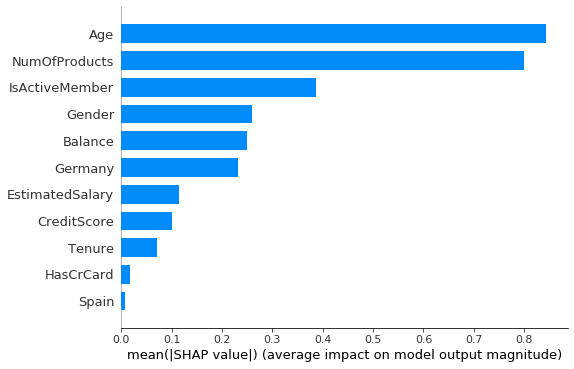

In [12]:
# Explain the model's predictions using SHAP values (the mean absolute value of the SHAP values for each feature)
explainer = shap.TreeExplainer(xgb1)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

The x-axis of the plot above is essentially the average magnitude change in model output when a feature is “hidden” from the model. We can see that the age feature is actually the most important, followed by the number of products and whether customer is active or not. The graphs suggest we can keep all of the features in the model. I will show other options from the shap package for the final model. 
For comparison, plot *gain* metric. 

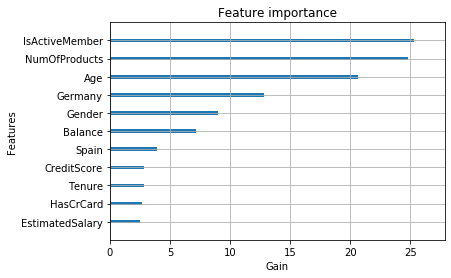

In [13]:
# plot of gain
xgb.plot_importance(xgb1, 
                    importance_type='gain', 
                    show_values = False, 
                    xlabel = 'Gain')

## 3.2 Tune max_depth and min_child_weight

* mean_child_weight (default=1)
For logistic regression it means something like "stop trying to split once you reach a certain degree of purity in a node and your model can fit it". 
Higher values prevent a model from learning relations which might be highly specific to the particular sample selected for a tree, hence it can be used to control over-fitting. 

* max_depth (default=3)
The maximum tree depth each individual tree can grow to. Also used to control over-fitting as higher depth will allow model to learn relations very specific to a particular sample. The default value of 3 is a good starting point, for less complex datasets there shouldn't be a need to go beyond 5. 

In [14]:
# Set number of estimators to 150 (learning from 3.1)
xgb2 =  XGBClassifier(learning_rate =0.1,
                      n_estimators=150,
                      objective= 'binary:logistic',
                      random_state=123)

paramset1 = {'max_depth': [2,3,4,5],
             'min_child_weight':range(1,20,2)}

# Define grid serach with 10-fold cross-validations. 
# The performace will be evaluated on 10 random validation datasets (within training dataset)
gsearch1 = GridSearchCV(estimator = xgb2,
                           param_grid = paramset1,
                           scoring = 'accuracy',
                           cv = 10,
                           n_jobs = -1)

gsearch1 = gsearch1.fit(X_train, y_train)

print('Best parameters values:', gsearch1.best_params_)
print('xgb2: best mean validation accuracy score:', gsearch1.best_score_)

Best parameters values: {'max_depth': 4, 'min_child_weight': 3}
xgb2: best mean validation accuracy score: 0.867


I will set max_depth to 4 and min_child_weight to 3 for further modelling. Increasing min_child_weight is one of the ways we can control over-fitting. 

## 3.3 Tune gamma
Gamma (default=0) is a minimum loss reduction required to make a further partition. Makes the algorithm conservative. The values can vary depending on the loss function and should be tuned. Gamma can take various values but I’ll check for 5 values here: [0.0, 0.1, 0.2, 0.3, 0.4]. 

In [15]:
paramset2 = {'gamma':[i/10.0 for i in range(0,5)]}

# Set parameters according to learning from Step 1 and 2, tune gamma

xgb3 =  XGBClassifier(learning_rate =0.1,
                      n_estimators=150,
                      max_depth = 4, 
                      min_child_weight = 3, 
                      objective= 'binary:logistic',
                      random_state=123)

gsearch2 = GridSearchCV(estimator = xgb3,
                           param_grid = paramset2,
                           scoring = 'accuracy',
                           cv = 10,
                           n_jobs = -1)
gsearch2

gsearch2 = gsearch2.fit(X_train, y_train)

print('Best parameters values:', gsearch2.best_params_)
print('xgb3: best mean validation accuracy score:', gsearch2.best_score_)

Best parameters values: {'gamma': 0.0}
xgb3: best mean validation accuracy score: 0.867


This shows that our original value of gamma, i.e. 0 is the optimum one (which is not suprising, setting it to higher number makes the algorithm conservative) 

## 3.4 Tune subsample and colsample_bytree
* subsample (default=1)
Subsample ratio of the training instances, range: (0,1]. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees, in every boosting iteration. Again, this can prevent overfitting.

* colsample_bytree [default=1]
Denotes the fraction of columns to be randomly sampled for each tree. Another way to avoid overtfitting. 

The next step would be try different subsample and colsample_bytree values. Lets take values 0.6,0.7,0.8,0.9 for both to start with.

In [16]:
paramset3 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

# Set parameters according to learning from Step 1, 2, 3
xgb4 =  XGBClassifier(learning_rate =0.1,
                      n_estimators=150,
                      max_depth = 4, 
                      min_child_weight = 3,
                      gamma = 0.0, 
                      objective= 'binary:logistic',
                      random_state=123)

gsearch3 = GridSearchCV(estimator = xgb4,
                           param_grid = paramset3,
                           scoring = 'accuracy',
                           cv = 10,
                           n_jobs = -1)

gsearch3 = gsearch3.fit(X_train, y_train)

print('Best parameters values:', gsearch3.best_params_)
print('xgb4: best mean validation accuracy score:', gsearch3.best_score_)

Best parameters values: {'colsample_bytree': 0.7, 'subsample': 0.6}
xgb4: best mean validation accuracy score: 0.867


The results show that using 70% of randomly selected variables for each tree and 60% of training data, subsampled randomly in each iteration, will not have a negative effect on the accuracy of the model, and it can pretend the model from over-fitting.

## 3.5 Tuning regularization parameters
Next step is to apply regularization to reduce overfitting, though many people don’t use these parameters much as gamma provides a substantial way of controlling complexity.

*reg_alpha* and *reg_lambda* control the L1 and L2 regularization terms, which in this case limit how extreme the weights at the leaves can become. These two regularization terms have different effects on the weights: L2 regularization (controlled by the lambda term, analogous to Ridge regression) encourages the weights to be small, 
whereas L1 regularization (controlled by the alpha term, analogous to Lasso regression) encourages sparsity — so it encourages weights to go to 0. This is helpful in models such as logistic regression, where you want some feature selection, but in decision trees we’ve already selected our features, so zeroing their weights isn’t super helpful. L2 regularization can be used in case of very high dimensionality so that the algorithm runs faster when implemented. 
For this reason, I expect setting a high lambda value and a low (or 0) alpha value to be the most effective regularizing strategy.

In [17]:
paramset4 = {
        'reg_alpha': [1e-5, 1e-2, 0.1, 0.2, 0.3],
        'reg_lambda': [1, 2, 5, 10]}

# Set parameters according to learning from previous steps

xgb5 =  XGBClassifier(learning_rate =0.1,
                      n_estimators=150,
                      max_depth = 4, 
                      min_child_weight = 3,
                      gamma = 0.0, 
                      colsample_bytree = 0.7,
                      subsample = 0.6,
                      objective= 'binary:logistic',
                      random_state=123)

gsearch4 = GridSearchCV(estimator = xgb5,
                           param_grid = paramset4,
                           scoring = 'accuracy',
                           cv = 10,
                           n_jobs = -1)

gsearch4 = gsearch4.fit(X_train, y_train)

print('Best parameters values:', gsearch4.best_params_)
print('xgb5: best mean validation accuracy score', gsearch4.best_score_)

Best parameters values: {'reg_alpha': 0.01, 'reg_lambda': 5}
xgb5: best mean validation accuracy score 0.868


Decreasing *reg_alpha* to 0.01 and increasing *reg_lambda* to 5 improves accuracy of the model on a validation dataset. 

## 3.6 Reducing learning rate

Lastly, we should lower the learning rate. Learning rate makes the model more robust by shrinking the weights on each step. Because of the additive nature of gradient boosted trees, getting stuck in local minima is a much smaller problem than with neural networks (or other learning algorithms which use stochastic gradient descent). The smaller the learning_rate the better the accuracy, but for very small values training time increases dramatically, therefore it is suggested to use minimum 0.01 for big datasets. 

In [18]:
paramset5 = {'learning_rate': [0.01, 0.05, 0.1]}

# Set parameters according to learning from all previous steps
xgb6 =  XGBClassifier(n_estimators=150,
                      max_depth = 4, 
                      min_child_weight = 3,
                      gamma = 0.0, 
                      colsample_bytree = 0.7,
                      subsample = 0.6,
                      reg_alpha = 0.01, 
                      reg_lambda = 5, 
                      objective= 'binary:logistic',
                      random_state=123)

gsearch5 = GridSearchCV(estimator = xgb6,
                           param_grid = paramset5,
                           scoring = 'accuracy',
                           cv = 10,
                           n_jobs = -1)

gsearch5 = gsearch5.fit(X_train, y_train)

print('Best parameter values:', gsearch5.best_params_)
print('xgb6: best mean validation accuracy score', gsearch5.best_score_)
gsearch5.cv_results_ 

Best parameter values: {'learning_rate': 0.1}
xgb6: best mean validation accuracy score 0.868


{'mean_fit_time': array([5.64917104, 4.95855207, 4.10621181]),
 'std_fit_time': array([2.3813094 , 1.81526735, 1.54543428]),
 'mean_score_time': array([0.02774897, 0.02493224, 0.01298015]),
 'std_score_time': array([0.02999428, 0.02684132, 0.00226467]),
 'param_learning_rate': masked_array(data=[0.01, 0.05, 0.1],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'learning_rate': 0.01},
  {'learning_rate': 0.05},
  {'learning_rate': 0.1}],
 'split0_test_score': array([0.84875, 0.855  , 0.8575 ]),
 'split1_test_score': array([0.85125, 0.87375, 0.88   ]),
 'split2_test_score': array([0.8575, 0.8675, 0.8775]),
 'split3_test_score': array([0.84875, 0.86   , 0.86   ]),
 'split4_test_score': array([0.86875, 0.87625, 0.875  ]),
 'split5_test_score': array([0.86125, 0.86875, 0.8675 ]),
 'split6_test_score': array([0.86625, 0.88625, 0.885  ]),
 'split7_test_score': array([0.84625, 0.85125, 0.85375]),
 'split8_test_score': array([0.85   , 0

The initial learning rate of 0.1 proved to offer the best results, accuracy of 0.868 on validation datasets. With all parameters tuned, I can now test the final model on test dataset. 

## 3.7 Validate the final model on test dataset

In [19]:
xgb_final =  XGBClassifier(n_estimators=300,
                      learning_rate = 0.1,
                      max_depth = 4, 
                      min_child_weight = 3,
                      gamma = 0.0, 
                      colsample_bytree = 0.7,
                      subsample = 0.6,
                      reg_alpha = 0.01, 
                      reg_lambda = 5, 
                      objective= 'binary:logistic',
                      random_state=123)

xgb_final.fit(X_train, y_train, 
         eval_set=[(X_train, y_train), (X_test, y_test)],
         eval_metric='auc',
         early_stopping_rounds = 0.01*(len(X_train)),
         verbose=True)
print(xgb_final)

[0]	validation_0-auc:0.677862	validation_1-auc:0.679682
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 80.0 rounds.
[1]	validation_0-auc:0.799895	validation_1-auc:0.79536
[2]	validation_0-auc:0.849735	validation_1-auc:0.846519
[3]	validation_0-auc:0.860691	validation_1-auc:0.858777
[4]	validation_0-auc:0.862332	validation_1-auc:0.863164
[5]	validation_0-auc:0.859583	validation_1-auc:0.861815
[6]	validation_0-auc:0.859013	validation_1-auc:0.864563
[7]	validation_0-auc:0.858057	validation_1-auc:0.862517
[8]	validation_0-auc:0.857112	validation_1-auc:0.861024
[9]	validation_0-auc:0.860114	validation_1-auc:0.861839
[10]	validation_0-auc:0.862718	validation_1-auc:0.863852
[11]	validation_0-auc:0.863377	validation_1-auc:0.864743
[12]	validation_0-auc:0.863092	validation_1-auc:0.864903
[13]	validation_0-auc:0.863595	validation_1-auc:0.864581
[14]	validation_0-auc:0.862319	validation_1-auc:0.8640

[141]	validation_0-auc:0.905008	validation_1-auc:0.87132
[142]	validation_0-auc:0.905328	validation_1-auc:0.871529
[143]	validation_0-auc:0.905588	validation_1-auc:0.871411
[144]	validation_0-auc:0.905927	validation_1-auc:0.871399
[145]	validation_0-auc:0.906012	validation_1-auc:0.871371
[146]	validation_0-auc:0.906137	validation_1-auc:0.871631
[147]	validation_0-auc:0.906183	validation_1-auc:0.871722
[148]	validation_0-auc:0.906353	validation_1-auc:0.871858
[149]	validation_0-auc:0.906494	validation_1-auc:0.871826
[150]	validation_0-auc:0.906578	validation_1-auc:0.871713
[151]	validation_0-auc:0.906849	validation_1-auc:0.871647
[152]	validation_0-auc:0.907016	validation_1-auc:0.871565
[153]	validation_0-auc:0.907321	validation_1-auc:0.871876
[154]	validation_0-auc:0.907504	validation_1-auc:0.871864
[155]	validation_0-auc:0.907775	validation_1-auc:0.871645
[156]	validation_0-auc:0.907903	validation_1-auc:0.871779
[157]	validation_0-auc:0.908117	validation_1-auc:0.871901
[158]	validatio

Accuracy on test dataset has increased from **0.8714** with the initial model to **0.8730** for the final model. We have achieved this result after fitting 78 trees (*Best iteration: [78]*)

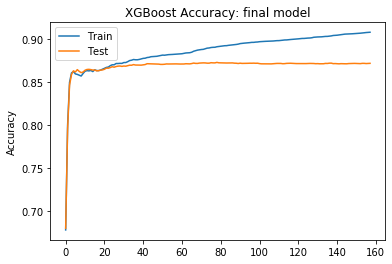

In [20]:
# Visualize training - how AUC improved for training and test dataset
xgb_final_evals_result = xgb_final.evals_result()
epochs = len(xgb_final_evals_result['validation_0']['auc'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, xgb_final_evals_result['validation_0']['auc'], label='Train')
ax.plot(x_axis, xgb_final_evals_result['validation_1']['auc'], label='Test')
ax.legend()
plt.ylabel('Accuracy')
plt.title('XGBoost Accuracy: final model')
plt.show()

## 3.8 Save final model to a file

In [21]:
xgb_forsave =  XGBClassifier(n_estimators=78,
                      learning_rate = 0.1,
                      max_depth = 4, 
                      min_child_weight = 3,
                      gamma = 0.0, 
                      colsample_bytree = 0.7,
                      subsample = 0.6,
                      reg_alpha = 0.01, 
                      reg_lambda = 5, 
                      objective= 'binary:logistic',
                      random_state=123)

xgb_forsave.fit(X_train, y_train, verbose=True)

# Save the final XGBoost model to x.dat pickle file in the current working directory.
pickle.dump(xgb_forsave, open('xgb_churn.dat', "wb"))

After a good night's sleep you may want to load the model and understand its predictions!

In [22]:
loaded_model = pickle.load(open('xgb_churn.dat', "rb"))
print(loaded_model)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=3, missing=nan, n_estimators=78, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=123,
              reg_alpha=0.01, reg_lambda=5, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.6, verbosity=1)


# 4. Interpretation of the model
I will explain some of the model's predictions on the entire dataset using the *shap* library. 
## 4.1 Global feature importance

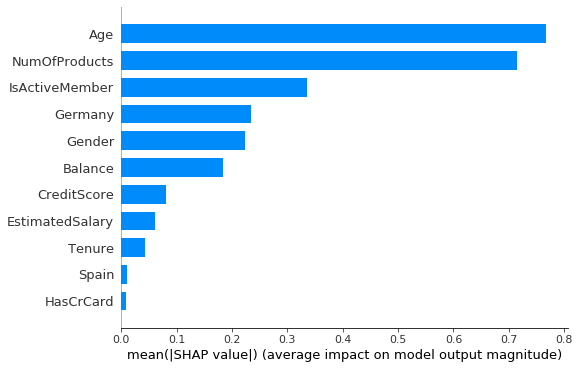

In [23]:
# Plot Feature Importance (SHAP values)
explainer = shap.TreeExplainer(loaded_model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X, plot_type="bar")

The x-axis is essentially the average magnitude change in model output when a feature is "hidden" from the model. We can see that the age feature is the strongest predictor of churn, followed by the number of products and (well behind) whether customer is active or not.

A bit more information can be extracted from a density scatter plot of SHAP values for each feature. It can be used to identify how much impact each feature has on the model output for individuals. In the plot below every customer has one dot on each row. Dots that don’t fit on the row pile up to show density. Since the XGBoost model has a logistic loss the x-axis has units of log-odds (Tree SHAP explains the change in the margin output of the model). The x position of the dot is the impact of that feature on the model’s prediction for the customer, and the color of the dot represents the value of that feature for the customer. The coloring by feature value shows us patterns such as how being older and not being active member increases chance of churn. An interesting pattern can be observed for number of products: while it is not the most important feature globally, it is by far the most important feature for a subset of customers, and high number of products decrease the chances of churn for some people, but can also increase for others. Hence, by plotting the impact of a feature on every sample we can also see important outlier effects.

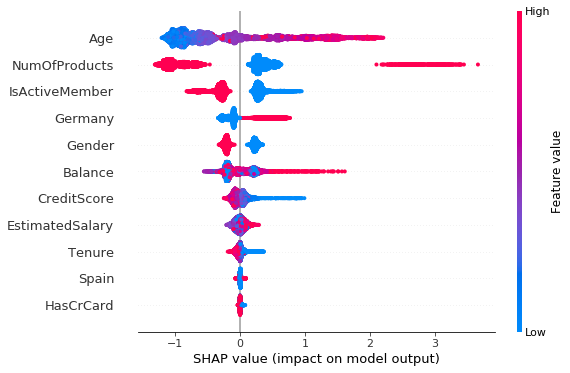

In [24]:
shap.summary_plot(shap_values, X)

Since SHAP values represent a feature's responsibility for a change in the model output, the plot represents the change in probability of churn as number of products changes. Vertical dispersion at a single value of RM represents interaction effects with other features. To help reveal these interactions dependence_plot automatically selects another feature for coloring. I will discuss it for a plot of age and being active/inactive member. 

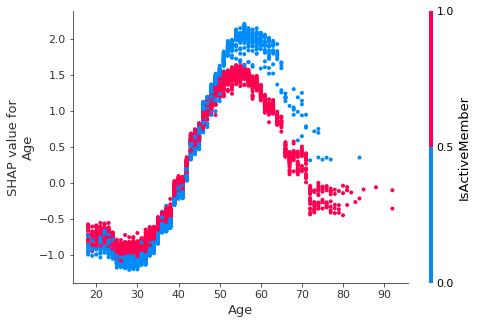

In [25]:
shap.dependence_plot("Age", shap_values, X)

The risk of churn reaches its peak for 50-60 year olds and among this group is higher for people who are not active members. However, among the youngest being an active member decreases the chances of churn *to a lesser extent* than being an inactive member. We found that people in their 20s and 30s and least likely to leave, in partuclar those who are not an active member (of the club/bank, whatever), while being 50-60 and inactive is a strong predictor of churn.  

Fast exact computation of pairwise interactions are implemented for tree models with *shap.TreeExplainer(model).shap_interaction_values(X)*. This returns a matrix for every prediction, where the main effects are on the diagonal and the interaction effects are off-diagonal. These values often reveal interesting hidden relationships. *shap_interaction_values* can be also used in dependence_plot. The one below involving age and number of products shows that the relationship between risk of churn and age varies for customers with different number of products in a bank. 

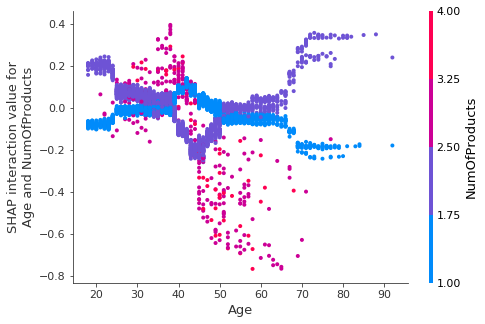

In [26]:
shap_interaction_values = explainer.shap_interaction_values(X)
shap.dependence_plot(
    ("Age", "NumOfProducts"),
    shap_interaction_values, X,
    display_features=X)

I have also observed an increased value for interaction effect for Balance and Tenure, which is visualized below. 

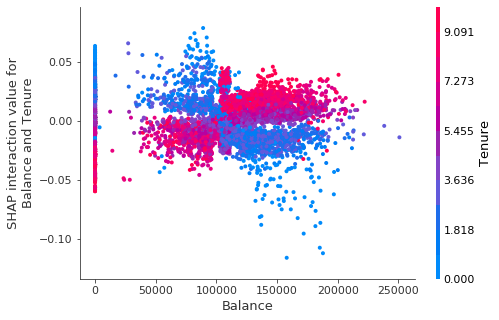

In [27]:
shap.dependence_plot(
    ("Balance", "Tenure"),
    shap_interaction_values, X,
    display_features=X)

## 4.2 Individual case prediction interpretation
With shap package we can also plot the feature importance for every customer in our data set since we have individualized explanations for every person. To understand how features are contributing to a prediction of each customer, we can use *shap.force_plot()* (use *matplotlib=True* to avoid Javascript. Otherwise, call: *shap.initjs()* first)

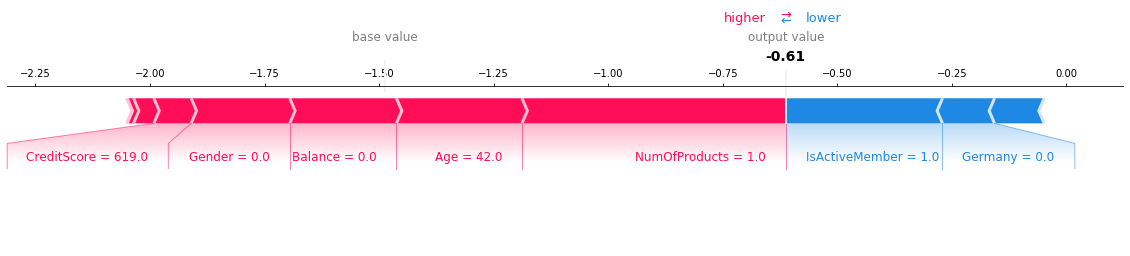

In [28]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:], matplotlib=True )

The above explanation shows features each contributing to push the model output from the base value (the average model output over the dataset we passed) to the model output. Features pushing the prediction (-0.61 in this case) higher are shown in red, those pushing the prediction lower are in blue. E.g. Having just one product, being 42, and a few other factors increased this customer's predicted probability of churn, but the fact that he/she is from Germany and is an active member pushed it down to -0.61 (below average model output from the whole dataset). 
For comparison, look at case no 2. 

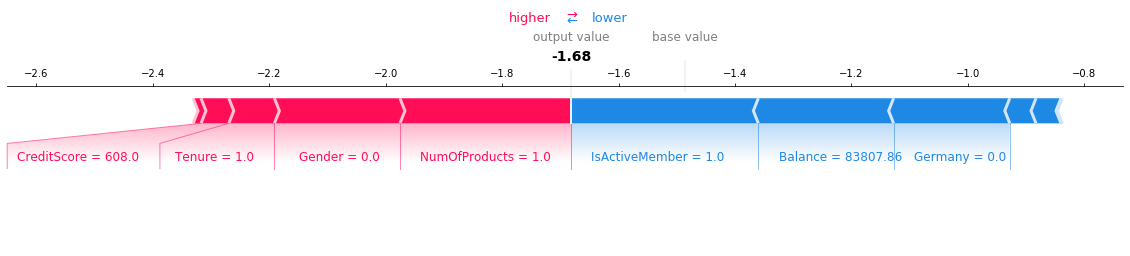

In [29]:
shap.force_plot(explainer.expected_value, shap_values[1,:], X.iloc[1,:], matplotlib=True )

## 4.3 Plot boosted tree
XGBoost model is a linear combination of decision trees. To make a prediction xgboost calculates predictions of individual trees and adds them. Therefore, you can interpret xgboost model by interpreting individual trees. 

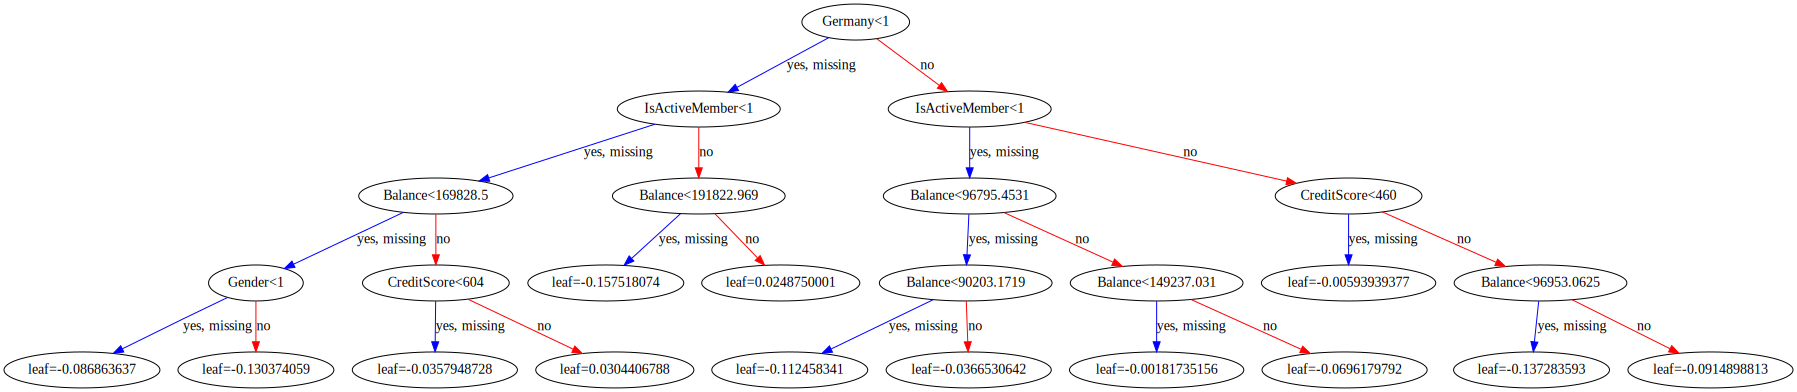

In [30]:
# This plots the first tree in the model (the tree at index 0)
xgb.to_graphviz(loaded_model)

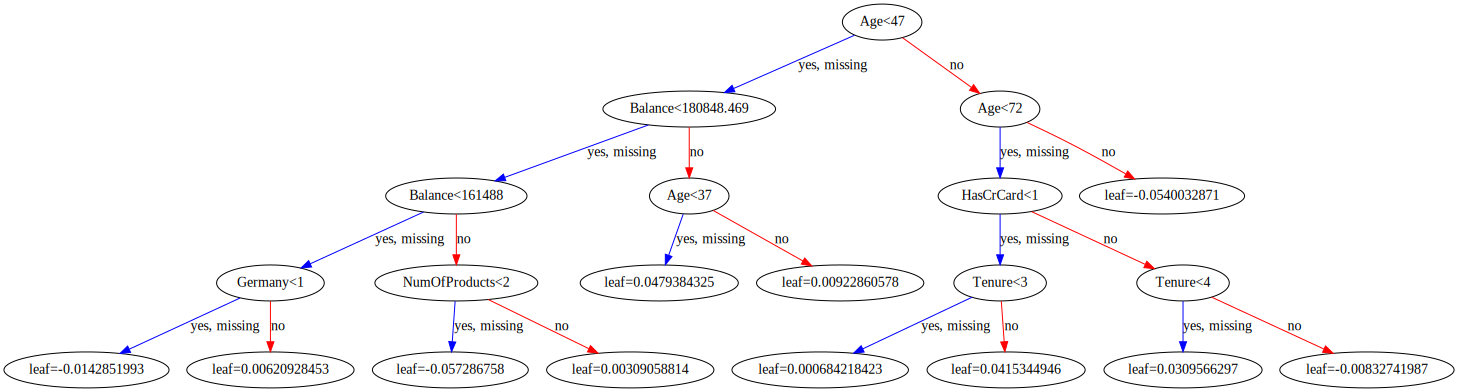

In [31]:
# This plots the last tree in the model (the tree at index 77)
xgb.to_graphviz(loaded_model, num_trees = 77)